In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import os
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader

In [0]:
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def load_img(folder):
    c = 0;
    images = [];
    for filename in os.listdir(folder): 
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); 
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        images.append(img);
    return images


In [0]:
def load_label_img(folder):
    images = [];
    c = 0;
    for filename in os.listdir(folder): 
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); 
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
        images.append(img);
    return images

In [0]:
def c2g(cn):
    cn = np.reshape(cn, (1, 1, 3));
    cn = cv2.cvtColor(cn, cv2.COLOR_BGR2GRAY);
    return cn;

colors = [];
colors.append(c2g(np.array([64, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 64], dtype = 'uint8')));

In [0]:
def class_pixel(label_img):
    class_pix = np.ones([128, 128, 1], dtype = int);
    for index, c in enumerate(colors):
        class_pix[label_img == c] = index; # Vectorized masking is much much faster
    return class_pix

In [0]:
def label_img_list(img_list):
    images = [];
    for image in img_list:
        images.append(class_pixel(image));
    return images;

In [0]:
transform_img = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_img_label = transforms.Compose([
    transforms.ToTensor()
])


In [0]:


class trainset(data.Dataset):
    def __init__(self, transform = None, root_train = None, root_train_label = None, transform_label = None):
        self.train_img = load_img(root_train);
        self.transform = transform;
        self.transform_label = transform_label;
        self.train_label_img = label_img_list(load_label_img(root_train_label));
        
    def __len__(self):
        return len(self.train_img);
    
    def __getitem__(self, index):
        img = self.transform(self.train_img[index]);
        label = self.transform_label(self.train_label_img[index]);
        return img, label;

class testset(data.Dataset):
    def __init__(self, transform = None, root_test = None, root_test_label = None, transform_label = None):
        self.test_img = load_img(root_test);
        self.transform = transform;
        self.transform_label = transform_label;
        self.test_label_img = label_img_list(load_label_img(root_test_label));
        
    def __len__(self):
        return len(self.test_img);
    
    def __getitem__(self, index):
        img = self.transform(self.test_img[index]);
        label = self.transform_label(self.test_label_img[index]);
        return img, label


In [14]:
traindataset = trainset(transform_img, '/content/gdrive/My Drive/CamVid/train/', '/content/gdrive/My Drive/CamVid/train_labels/', transform_img_label);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
testdataset = testset(transform_img, '/content/gdrive/My Drive/CamVid/test/', '/content/gdrive/My Drive/CamVid/test_labels/', transform_img_label);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62

In [31]:
train_loader = data.DataLoader(traindataset, batch_size = 1, shuffle=True,  num_workers=4)
test_loader = data.DataLoader(testdataset, batch_size = 1, shuffle=True,  num_workers=4)

AttributeError: ignored

In [0]:
class unet(nn.Module):
  def __init__(self):
    super().__init__();
    self.conv1 = nn.Conv2d(3, 64, 3);
    self.conv2 = nn.Conv2d(64, 128, 3);
    self.conv3 = nn.Conv2d(128, 256, 3);
    self.conv4 = nn.Conv2d(256, 512, 3);
    self.conv5 = nn.Conv2d(512, 1024, 3);
    self.conv6 = nn.Conv2d(1024, 512, 3);
    self.conv7 = nn.Conv2d(512, 512, 3);
    self.conv8 = nn.Conv2d(512, 256, 3);
    self.conv9 = nn.Conv2d(256, 256, 3);
    self.conv10 = nn.Conv2d(256, 128, 3);
    self.conv11 = nn.Conv2d(128, 128, 3);
    self.b1 = nn.BatchNorm2d(64);
    self.b2 = nn.BatchNorm2d(128);
    self.b3 = nn.BatchNorm2d(256);
    self.b4 = nn.BatchNorm2d(512);
    self.b5 = nn.BatchNorm2d(1024);
    self.convT1 = nn.ConvTranspose2d(1024, 512, 2, 2);
    self.convT2 = nn.ConvTranspose2d(512, 256, 2, 2);
    self.convT3 = nn.ConvTranspose2d(256, 256, 2, 2);
    self.convT4 = nn.ConvTranspose2d(128, 64, 2, 2);
    self.convT5 = nn.ConvTranspose2d(64, 32, 2, 2);
    self.pool1 = nn.MaxPool2d(2, 2);

  def forward(self, x):
    x = F.relu(self.b1(self.conv1(x)));
    x = F.relu(self.b2(self.conv2(x)));
    x = self.pool1(x);
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b3(self.conv3(x)));
    x1 = x;
    x1 = x1[:, :, int((58 - 24)/2) : int((58 + 24)/2), int((58 - 24)/2) : int((58 + 24)/2)];
    x = self.pool1(x);
    x = F.relu(self.b3(self.conv9(x)));
    x = F.relu(self.b4(self.conv4(x)));
    x2 = x;
    x2 = x2[:, :, int((25 - 16)/2) : int((25 + 16)/2), int((25 - 16)/2) : int((25 + 16)/2)];
    x = self.pool1(x);
    x = F.relu(self.b4(self.conv7(x)));
    x = F.relu(self.b5(self.conv5(x)));
    x = self.b4(self.convT1(x));
    x = torch.cat((x2, x), dim = 1);
    x = F.relu(self.b4(self.conv6(x)));
    x = F.relu(self.b4(self.conv7(x)));
    x = self.b3(self.convT2(x));
    x = torch.cat((x1, x), dim = 1);
    x = F.relu(self.b3(self.conv8(x)));
    x = F.relu(self.b3(self.conv9(x)));
    x = self.b3(self.convT3(x));
    x = F.relu(self.b2(self.conv10(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = F.relu(self.b2(self.conv11(x)));
    x = self.b1(self.convT4(x));
    x = self.convT5(x);
    del x1;
    del x2;
    return x;
  

    




In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
Unet = unet()
Unet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet.parameters(), lr = 0.00035, betas = (0.9, 0.9995), eps = 1e-08, weight_decay=0.0001, amsgrad=False)

cpu


In [0]:
print(labels.size())
for i, data in enumerate(train_loader):  
    inputs, labels = data;
    print(labels.size())
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.reshape(16, 128, 128);
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.reshape(15, 128, 128);

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([15, 1, 128, 128])


In [0]:
for i, data in enumerate(train_loader):  
    inputs, labels = data;
    print(labels.size())
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.reshape(16, 128, 128);
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.reshape(15, 128, 128);
    print(labels.size())

torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 128, 128])
torch.Size([16, 1, 128, 128])
t

In [0]:
for epoch in range(200):
  for i, data in enumerate(train_loader):  
    inputs, labels = data
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.reshape(16, 128, 128)
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.reshape(15, 128, 128)
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = Unet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if loss.item() < 0.7:
      break;
  if loss.item() < 0.7:
    break;
  print(loss.item());
    

1.2881439924240112
1.164389967918396
1.1377949714660645
1.0439916849136353
1.1531018018722534
1.063565969467163
1.2467867136001587
1.1769050359725952
1.1823316812515259
1.206400990486145
1.0248554944992065
1.1159948110580444
1.088545560836792
1.03456711769104
1.1500884294509888
1.0995864868164062
1.1043148040771484
1.0286616086959839
1.0538477897644043
0.9890320301055908
1.1451241970062256
0.8963101506233215
0.9761496186256409
1.0087217092514038
1.055665373802185
1.028148889541626
1.024503469467163
0.9228987097740173
1.0307191610336304
0.8843944072723389
0.8579906225204468
0.9910902380943298
0.9727128744125366
0.9836959838867188
1.1089366674423218
1.0385189056396484
1.0649999380111694
0.8675773739814758
0.818588137626648
0.8607218861579895
0.7983148694038391
0.8305938243865967
0.9184752702713013
0.792018711566925
0.8523731231689453
0.775463342666626
0.8188102841377258
0.804477870464325
0.8130227327346802
0.8014018535614014


In [28]:
for epoch in range(200):
  for i, data in enumerate(train_loader):  
    inputs, labels = data
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.reshape(16, 128, 128)
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.reshape(15, 128, 128)
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = Unet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i%10 == 0 :
      print(loss.item());
    if loss.item() < 0.7:
      break;
  if loss.item() < 0.7:
    break;
  print('Epoch ', epoch,':' ,loss.item());
    

3.530881881713867
3.129446506500244
2.8685266971588135
Epoch  0 : 2.816535711288452
2.8113396167755127
2.6210615634918213
2.388024091720581
Epoch  1 : 2.4865498542785645
2.3897061347961426
2.2689809799194336
2.1540844440460205
Epoch  2 : 2.2466766834259033
2.2129595279693604


KeyboardInterrupt: ignored

In [32]:
for epoch in range(200):
  for i, data in enumerate(train_loader):  
    inputs, labels = data
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.reshape(16, 128, 128)
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.reshape(15, 128, 128)
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = Unet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i%10 == 0 :
      print(loss.item());
    if loss.item() < 0.7:
      break;
  if loss.item() < 0.7:
    break;
  print('Epoch ', epoch,':' ,loss.item());
    

2.0586183071136475
2.0897274017333984
1.969056487083435
Epoch  0 : 2.1185293197631836
1.959905743598938
1.9573519229888916
1.8245397806167603
Epoch  1 : 1.8767142295837402
1.8353726863861084
1.8308372497558594
1.8085182905197144
Epoch  2 : 1.9185560941696167
1.740673303604126
1.6812183856964111
1.8060299158096313
Epoch  3 : 1.7229886054992676
1.6998615264892578
1.6338964700698853
1.812474012374878
Epoch  4 : 1.6025503873825073
1.6548525094985962
1.6986297369003296
1.6622750759124756
Epoch  5 : 1.529331922531128
1.7182480096817017
1.8372617959976196
1.58887779712677
Epoch  6 : 1.614675521850586
1.5481674671173096
1.541333556175232
1.641022801399231
Epoch  7 : 1.5081961154937744
1.5221939086914062
1.5361751317977905
1.524596095085144
Epoch  8 : 1.4988837242126465
1.4539579153060913
1.4639081954956055
1.6601816415786743
Epoch  9 : 1.4846378564834595
1.4152653217315674
1.700921893119812
1.7043825387954712
Epoch  10 : 1.539312720298767
1.5727877616882324
1.6049838066101074
1.464506506919860

In [33]:
print(loss.item())

0.6773749589920044


In [0]:
PATH = '/content/gdrive/My Drive/CamVid/saved.pth'
torch.save(Unet.state_dict(),PATH)

In [36]:
PATH = '/content/gdrive/My Drive/CamVid/saved.pth'
Unet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
def corr(x): 
    x = x.cpu()
    x = x.detach().numpy()
    x = x.argmax(axis = 1);
    return x

In [42]:
correct = 0;
total = 0;
for i, data in enumerate(train_loader):
    print(i,'.',' Correct:',correct,' Total:', total)
    inputs, labels = data
    inputs = inputs.to(device)
    outputs = Unet.forward(inputs)
    outputs = corr(outputs)
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.detach().numpy()
      labels = labels.reshape(16, 128, 128)
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.detach().numpy()
      labels = labels.reshape(15, 128, 128)
    outputs = outputs.reshape(16, 128, 128)
    for i in range(128):
      for j in range(128):
        for k in range(1):
          total = total + 1;
          if outputs[k, i, j] == labels[k, i, j]:
            correct = correct + 1;
print("test set accuracy:", (correct/total) * 100)

0 .  Correct: 0  Total: 0
1 .  Correct: 11776  Total: 16384
2 .  Correct: 24381  Total: 32768
3 .  Correct: 38190  Total: 49152
4 .  Correct: 51186  Total: 65536
5 .  Correct: 61637  Total: 81920
6 .  Correct: 75670  Total: 98304
7 .  Correct: 88544  Total: 114688
8 .  Correct: 102597  Total: 131072
9 .  Correct: 115512  Total: 147456
10 .  Correct: 128677  Total: 163840
11 .  Correct: 142101  Total: 180224
12 .  Correct: 153827  Total: 196608
13 .  Correct: 166736  Total: 212992
14 .  Correct: 180031  Total: 229376
15 .  Correct: 193002  Total: 245760
16 .  Correct: 205122  Total: 262144
17 .  Correct: 217381  Total: 278528
18 .  Correct: 228957  Total: 294912
19 .  Correct: 243631  Total: 311296
20 .  Correct: 258549  Total: 327680
21 .  Correct: 271201  Total: 344064
22 .  Correct: 284106  Total: 360448


ValueError: ignored

In [52]:
correct = 0;
total = 0;
for i, data in enumerate(train_loader):
    print(i,'.',' Correct:',correct,' Total:', total)
    inputs, labels = data
    inputs = inputs.to(device)
    outputs = Unet.forward(inputs)
    outputs = corr(outputs)
    if labels.size() == torch.Size([16, 1, 128, 128]):
      labels = labels.detach().numpy()
      labels = labels.reshape(16, 128, 128)
    elif labels.size() == torch.Size([15, 1, 128, 128]):
      labels = labels.detach().numpy()
      labels = labels.reshape(15, 128, 128)
    if outputs.shape == (16, 1, 128, 128):
      outputs = outputs.reshape(16, 128, 128)
    elif outputs.shape == (15, 1, 128, 128):
      outputs = outputs.reshape(15, 128, 128)
    for i in range(128):
      for j in range(128):
        for k in range(1):
          total = total + 1;
          if outputs[k, i, j] == labels[k, i, j]:
            correct = correct + 1;
print("test set accuracy:", (correct/total) * 100)

0 .  Correct: 0  Total: 0
1 .  Correct: 12490  Total: 16384
2 .  Correct: 26127  Total: 32768
3 .  Correct: 40191  Total: 49152
4 .  Correct: 53063  Total: 65536
5 .  Correct: 66236  Total: 81920
6 .  Correct: 78992  Total: 98304
7 .  Correct: 90804  Total: 114688
8 .  Correct: 103648  Total: 131072
9 .  Correct: 116346  Total: 147456
10 .  Correct: 129547  Total: 163840
11 .  Correct: 143533  Total: 180224
12 .  Correct: 156660  Total: 196608
13 .  Correct: 170192  Total: 212992
14 .  Correct: 182996  Total: 229376
15 .  Correct: 196040  Total: 245760
16 .  Correct: 208711  Total: 262144
17 .  Correct: 221071  Total: 278528
18 .  Correct: 234142  Total: 294912
19 .  Correct: 246959  Total: 311296
20 .  Correct: 260610  Total: 327680
21 .  Correct: 272805  Total: 344064
22 .  Correct: 286010  Total: 360448
test set accuracy: 79.41204568614131


In [51]:
print(outputs.shape)


(16, 128, 128)


In [0]:
colors = [];
colors.append(np.array([64, 128, 64], dtype = 'uint8'))
colors.append(np.array([128, 0, 192], dtype = 'uint8'))
colors.append(np.array([192, 128, 0], dtype = 'uint8'))
colors.append(np.array([64, 128, 0], dtype = 'uint8'))
colors.append(np.array([0, 0, 128], dtype = 'uint8'))
colors.append(np.array([128, 0, 64], dtype = 'uint8'))
colors.append(np.array([192, 0, 64], dtype = 'uint8'))
colors.append(np.array([64, 128, 192], dtype = 'uint8'))
colors.append(np.array([128, 192, 192], dtype = 'uint8'))
colors.append(np.array([128, 64, 64], dtype = 'uint8'))
colors.append(np.array([192, 0, 128], dtype = 'uint8'))
colors.append(np.array([64, 0, 192], dtype = 'uint8'))
colors.append(np.array([64, 128, 128], dtype = 'uint8'))
colors.append(np.array([192, 0, 192], dtype = 'uint8'))
colors.append(np.array([64, 64, 128], dtype = 'uint8'))
colors.append(np.array([128, 192, 64], dtype = 'uint8'))
colors.append(np.array([0, 64, 64], dtype = 'uint8'))
colors.append(np.array([128, 64, 128], dtype = 'uint8'))
colors.append(np.array([192, 128, 128], dtype = 'uint8'))
colors.append(np.array([192, 0, 0], dtype = 'uint8'))
colors.append(np.array([128, 128, 192], dtype = 'uint8'))
colors.append(np.array([128, 128, 128], dtype = 'uint8'))
colors.append(np.array([192, 128, 64], dtype = 'uint8'))
colors.append(np.array([64, 0, 0], dtype = 'uint8'))
colors.append(np.array([64, 64, 0], dtype = 'uint8'))
colors.append(np.array([128, 64, 192], dtype = 'uint8'))
colors.append(np.array([0, 128, 128], dtype = 'uint8'))
colors.append(np.array([192, 128, 192], dtype = 'uint8'))
colors.append(np.array([64, 0, 64], dtype = 'uint8'))
colors.append(np.array([0, 192, 192], dtype = 'uint8'))
colors.append(np.array([0, 0, 0], dtype = 'uint8'))
colors.append(np.array([0, 192, 64], dtype = 'uint8'))

def test(op_img):
    class_pix = np.ones([128, 128, 3], dtype = 'uint8')
    for index, c in enumerate(colors):
        class_pix[op_img == index] = c; 
    return class_pix.reshape((128, 128, 3))


In [57]:
print(type(test(outputs[0])));
outim = test(outputs[0]);
outim = outim.reshape([128, 128, 3])
print(outim.shape)
cv2_imshow(outim)

<class 'numpy.ndarray'>
(128, 128, 3)


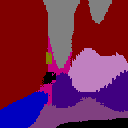

In [58]:
cv2_imshow(outim)

0 .


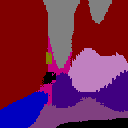

1 .


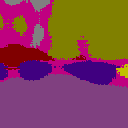

2 .


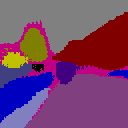

3 .


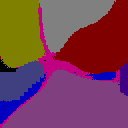

4 .


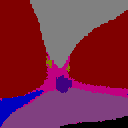

5 .


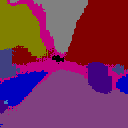

6 .


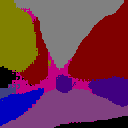

7 .


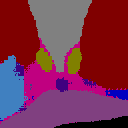

8 .


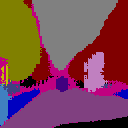

9 .


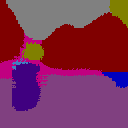

10 .


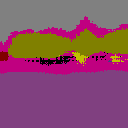

11 .


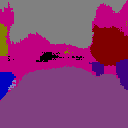

12 .


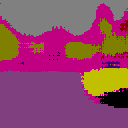

13 .


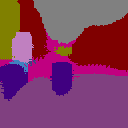

14 .


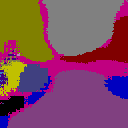

In [62]:
for i in range(15):
  outim = test(outputs[i]);
  outim = outim.reshape([128, 128, 3])
  print(i,'.')
  cv2_imshow(outim)